In [1]:
import os
import cv2
import gc
import torch
import optuna
import datetime
import numpy as np
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import pickle
import io
import lmdb  # pip install lmdb
import logging
import sqlite3
from optuna.pruners import MedianPruner
from torch.utils.data import DataLoader
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import timm  # pip install timm
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

logging.basicConfig(level=logging.INFO)

# ------------------------------
# CONSTANTS & HYPERPARAMETERS
# ------------------------------
GRADIENT_ACCUM_STEPS = 4       # Accumulate gradients over 4 mini-batches (simulate effective batch size = mini-batch * 4)
NUM_FRAMES = 30                # Use 30 frames per video
IMG_SIZE = 224                 # Use 224x224 images (matching your existing cache files)
# (Cache files are named like precomputed_TrainLabels_frame_30.pkl and lmdb_TrainLabels_frame_30)

# ------------------------------
# Environment & Paths
# ------------------------------
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

BASE_DIR = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project")
DATA_DIR = BASE_DIR / "data" / "DAiSEE"
FRAMES_DIR = DATA_DIR / "ExtractedFrames"
LABELS_DIR = DATA_DIR / "Labels"
MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR = BASE_DIR / "cache"
CACHE_DIR.mkdir(exist_ok=True)

print("Models directory exists:", os.path.exists(MODEL_DIR))
print("Checkpoint path writable:", os.access(MODEL_DIR, os.W_OK))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------
# Data Transforms
# ------------------------------
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Models directory exists: True
Checkpoint path writable: True
Using device: cuda


In [2]:
# ------------------------------
# Helper Functions
# ------------------------------
def get_csv_clip_id(video_stem: str) -> str:
    base = video_stem.strip()
    return base.replace("110001", "202614", 1) if base.startswith("110001") else base

def select_impactful_frames(video_folder: Path, num_frames=30):
    # For speed, we select evenly spaced frames.
    frame_files = sorted(video_folder.glob("frame_*.jpg"))
    total_frames = len(frame_files)
    if total_frames == 0:
        return []
    if total_frames <= num_frames:
        return frame_files
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    return [frame_files[i] for i in indices]

def precompute_best_frames(csv_file: Path, video_root: Path, num_frames=30):
    """
    Precompute and cache the selected frame file paths for each video.
    Saves a .pkl file with keys "valid_indices" and "precomputed_frames".
    (e.g., precomputed_TrainLabels_frame_30.pkl)
    """
    data = pd.read_csv(csv_file, dtype=str)
    data.columns = data.columns.str.strip()
    split = csv_file.stem.replace("Labels", "").strip()
    valid_indices = []
    precomputed = []
    skipped_count = 0
    for idx, row in tqdm(data.iterrows(), total=len(data), desc="Precomputing frames"):
        clip_id = get_csv_clip_id(row["ClipID"].split('.')[0])
        video_folder = video_root / split / clip_id
        if video_folder.exists():
            frames = select_impactful_frames(video_folder, num_frames)
            if len(frames) >= num_frames:
                precomputed.append(frames[:num_frames])
                valid_indices.append(idx)
            else:
                skipped_count += 1
        else:
            skipped_count += 1
    print(f"Precomputation: Skipped {skipped_count} videos out of {len(data)}.")
    cache_data = {"valid_indices": valid_indices, "precomputed_frames": precomputed}
    cache_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}.pkl"
    with open(cache_file, "wb") as f:
        pickle.dump(cache_data, f)
    print(f"Precomputed results saved to {cache_file}")
    return cache_data

def convert_pkl_to_lmdb(csv_file: Path, num_frames=30, transform=train_transform, lmdb_map_size=1 * 1024**3):
    """
    Convert the precomputed .pkl file into an LMDB database containing preprocessed
    feature tensors (in half precision) extracted by an EfficientNetV2-L backbone.
    (Reuses your existing filenames for 224×224 files, e.g., lmdb_TrainLabels_frame_30)
    """
    pkl_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}.pkl"
    lmdb_path = CACHE_DIR / f"lmdb_{csv_file.stem}_frame_{num_frames}"
    # Check if LMDB exists by testing for data.mdb in lmdb_path
    if (lmdb_path / "data.mdb").exists():
        print(f"LMDB database already exists at {lmdb_path}")
        return lmdb_path

    env = lmdb.open(str(lmdb_path), map_size=lmdb_map_size)
    if not pkl_file.exists():
        precompute_best_frames(csv_file, FRAMES_DIR, num_frames=num_frames)
    with open(pkl_file, "rb") as f:
        cache = pickle.load(f)
    valid_indices = cache["valid_indices"]
    file_paths_list = cache["precomputed_frames"]

    # Use the correct timm model name for EfficientNetV2-L:
    backbone = timm.create_model("tf_efficientnetv2_l", pretrained=True)
    backbone.reset_classifier(0)
    backbone.eval()
    backbone.to(device)
    for param in backbone.parameters():
        param.requires_grad = False

    print("Converting file paths to LMDB preprocessed feature tensors...")
    with env.begin(write=True) as txn:
        for idx, paths in tqdm(enumerate(file_paths_list), total=len(file_paths_list)):
            video_features = []
            for fp in paths:
                try:
                    img = Image.open(fp).convert("RGB")
                except Exception:
                    img = Image.new('RGB', (IMG_SIZE, IMG_SIZE))
                tensor = transform(img).unsqueeze(0).to(device)
                with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
                    feat = backbone(tensor)
                    # backbone output for tf_efficientnetv2_l is 1536-dimensional
                    feat = feat.squeeze(0).cpu().half()
                video_features.append(feat)
            if video_features:
                video_features = torch.stack(video_features)  # shape: [num_frames, feature_dim]
                key = f"video_{valid_indices[idx]}".encode("utf-8")
                txn.put(key, pickle.dumps(video_features))
    env.close()
    print(f"LMDB database created at {lmdb_path}")
    return lmdb_path

In [3]:
# ------------------------------
# LMDB Dataset Class (Corrected)
# ------------------------------
class VideoDatasetLMDB(torch.utils.data.Dataset):
    def __init__(self, csv_file, lmdb_path, num_frames=30):
        self.data = pd.read_csv(csv_file, dtype=str)
        self.data.columns = self.data.columns.str.strip()
        pkl_file = CACHE_DIR / f"precomputed_{csv_file.stem}_frame_{num_frames}.pkl"
        with open(pkl_file, "rb") as f:
            cache = pickle.load(f)
        self.valid_indices = cache["valid_indices"]
        self.data = self.data.iloc[self.valid_indices].reset_index(drop=True)
        self.num_frames = num_frames
        self.lmdb_path = str(lmdb_path)
        self.env = None

    def _init_env(self):
        if self.env is None:
            self.env = lmdb.open(self.lmdb_path, readonly=True, lock=False, readahead=False, meminit=False)
        return self.env

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        env = self._init_env()
        original_idx = self.valid_indices[idx]
        key = f"video_{original_idx}".encode("utf-8")
        with env.begin(write=False) as txn:
            data_bytes = txn.get(key)
            if data_bytes is None:
                raise IndexError(f"Key {key} not found in LMDB")
            features = pickle.loads(data_bytes)
        labels = self.data.iloc[idx][["Engagement", "Boredom", "Confusion", "Frustration"]].astype(int)
        return features, torch.tensor(labels.values, dtype=torch.long)

# ------------------------------
# CBAM Modules
# ------------------------------
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Conv1d(in_channels, in_channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels // reduction, in_channels, kernel_size=1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x_cat))

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)
    def forward(self, x):
        out = x * self.channel_attention(x)
        out = out * self.spatial_attention(out)
        return out

# ------------------------------
# Model Architecture: EfficientNetV2L + TCN + CBAM
# ------------------------------
class EfficientNetV2L_TCN_CBAM(nn.Module):
    def __init__(self, feature_dim=1536, tcn_channels=256, hidden_size=128, num_layers=1, cbam_reduction=16):
        """
        feature_dim: for tf_efficientnetv2_l, the output dimension is 1536.
        tcn_channels: number of channels used in the TCN block.
        hidden_size: size of the final classifier hidden layer.
        num_layers: number of TCN layers (here we use one block).
        """
        super(EfficientNetV2L_TCN_CBAM, self).__init__()
        self.backbone = timm.create_model("tf_efficientnetv2_l", pretrained=True)
        self.backbone.reset_classifier(0)
        self.feature_dim = feature_dim
        self.tcn = nn.Sequential(
            nn.Conv1d(self.feature_dim, tcn_channels, kernel_size=3, dilation=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(tcn_channels, self.feature_dim, kernel_size=1)
        )
        self.cbam = CBAM(self.feature_dim, reduction=cbam_reduction, kernel_size=7)
        self.classifier = nn.Linear(self.feature_dim, 16)  # will be reshaped to (4,4)
        
    def forward(self, x):
        # If input is pre-extracted features (3D: [B, T, feature_dim]), then skip backbone.
        if x.dim() == 3:
            x = x.permute(0, 2, 1)  # (B, feature_dim, T)
        else:
            # Otherwise, assume raw images: (B, T, C, H, W)
            B, T, C, H, W = x.size()
            x = x.view(-1, C, H, W)
            features = self.backbone(x)
            features = features.view(B, T, self.feature_dim)
            x = features.permute(0, 2, 1)
        tcn_out = self.tcn(x)          # (B, feature_dim, T)
        attn_out = self.cbam(tcn_out)   # (B, feature_dim, T)
        pooled = attn_out.mean(dim=2)   # (B, feature_dim)
        logits = self.classifier(pooled)  # (B, 16)
        return logits.view(-1, 4, 4)

In [4]:
# ------------------------------
# Training Function with Gradient Accumulation
# ------------------------------
def train_model(model, train_loader, val_loader, epochs, lr, checkpoint_path, patience=5, gradient_accum_steps=GRADIENT_ACCUM_STEPS):
    model.to(device, non_blocking=True)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler = GradScaler()
    if checkpoint_path.exists():
        state = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(state["model_state_dict"])
        optimizer.load_state_dict(state["optimizer_state_dict"])
        start_epoch = state["epoch"]
        best_val_loss = state["best_val_loss"]
    else:
        start_epoch, best_val_loss = 0, float('inf')
    loss_fn = nn.CrossEntropyLoss().to(device)
    early_stop_counter = 0
    checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0
        for i, (features, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]")):
            features = features.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(features)
                outputs = outputs.view(outputs.size(0), 4, 4)
                loss = sum(loss_fn(outputs[:, d], labels[:, d]) for d in range(4)) / 4.0
            scaler.scale(loss / gradient_accum_steps).backward()
            if (i + 1) % gradient_accum_steps == 0:
                scaler.step(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.update()
                optimizer.zero_grad()
            running_loss += loss.item() * features.size(0)
            del features, labels, outputs, loss
            if (i + 1) % 30 == 0:
                torch.cuda.empty_cache()
                gc.collect()
        train_loss = running_loss / len(train_loader.dataset)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
            for features, labels in val_loader:
                features = features.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                outputs = model(features)
                outputs = outputs.view(outputs.size(0), 4, 4)
                loss = sum(loss_fn(outputs[:, d], labels[:, d]) for d in range(4)) / 4.0
                val_loss += loss.item() * features.size(0)
        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            state = {
                "epoch": epoch + 1,
                "best_val_loss": best_val_loss,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict()
            }
            temp_path = checkpoint_path.with_suffix(".tmp")
            torch.save(state, temp_path, _use_new_zipfile_serialization=False)
            if checkpoint_path.exists():
                checkpoint_path.unlink()
            temp_path.rename(checkpoint_path)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best loss: {best_val_loss:.4f}")
            break
    return best_val_loss

# ------------------------------
# Hyperparameter Tuning with Optuna (LMDB dataset)
# ------------------------------
def objective(trial):
    torch.cuda.empty_cache()
    gc.collect()
    num_frames = trial.suggest_categorical("num_frames", [NUM_FRAMES])
    batch_size = trial.suggest_categorical("batch_size", [2, 4, 8, 16])
    lr = trial.suggest_float("lr", 1e-5, 5e-4, log=True)
    epochs = trial.suggest_categorical("epochs", [3, 5, 10, 15])
    hidden_size = trial.suggest_categorical("hidden_size", [64, 128])
    num_lstm_layers = trial.suggest_categorical("num_lstm_layers", [1, 2])
    
    train_set = VideoDatasetLMDB(LABELS_DIR / "TrainLabels.csv",
                  CACHE_DIR / f"lmdb_{(LABELS_DIR / 'TrainLabels.csv').stem}_frame_{NUM_FRAMES}",
                  num_frames=num_frames)
    val_set = VideoDatasetLMDB(LABELS_DIR / "ValidationLabels.csv",
                  CACHE_DIR / f"lmdb_{(LABELS_DIR / 'ValidationLabels.csv').stem}_frame_{NUM_FRAMES}",
                  num_frames=num_frames)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                              num_workers=2, pin_memory=True, prefetch_factor=1)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                            num_workers=2, pin_memory=True, prefetch_factor=1)
    
    # Note: Set feature_dim to 1536 as per tf_efficientnetv2_l backbone
    model = EfficientNetV2L_TCN_CBAM(feature_dim=1536, hidden_size=hidden_size, num_layers=num_lstm_layers).to(device)
    trial_checkpoint = MODEL_DIR / f"lmdb_trial_eff_v2l_{trial.number}_checkpoint.pth"
    trial_checkpoint.parent.mkdir(parents=True, exist_ok=True)
    try:
        best_loss = train_model(model, train_loader, val_loader, epochs, lr, trial_checkpoint,
                                patience=3, gradient_accum_steps=GRADIENT_ACCUM_STEPS)
    except Exception as e:
        if trial_checkpoint.exists():
            trial_checkpoint.unlink()
        print(f"Trial {trial.number} failed: {e}")
        best_loss = float("inf")
    del model, train_loader, val_loader, train_set, val_set
    torch.cuda.empty_cache()
    gc.collect()
    return best_loss

# ------------------------------
# Evaluation Function (LMDB dataset)
# ------------------------------
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, test_loader):
    """Evaluate model with post-processing to address class imbalance issues"""
    model.eval()
    emotions = ["Engagement", "Boredom", "Confusion", "Frustration"]
    
    # Target distributions for each emotion (based on training data)
    target_distributions = {
        "Engagement": np.array([0.005, 0.05, 0.51, 0.435]),
        "Boredom": np.array([0.46, 0.32, 0.20, 0.02]),
        "Confusion": np.array([0.693, 0.22, 0.075, 0.012]),
        "Frustration": np.array([0.78, 0.17, 0.035, 0.015])
    }
    
    # Store predictions and labels
    all_outputs = {emotion: [] for emotion in emotions}
    all_labels = {emotion: [] for emotion in emotions}
    
    with torch.no_grad(), autocast(device_type='cuda', dtype=torch.float16):
        for features, labels in tqdm(test_loader, desc="Evaluating"):
            features = features.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(features)
            outputs = outputs.view(outputs.size(0), 4, 4)
            
            # Store outputs and labels for each emotion
            for i, emotion in enumerate(emotions):
                all_outputs[emotion].append(outputs[:, i].cpu())
                all_labels[emotion].append(labels[:, i].cpu())
    
    # Process each emotion separately
    results = {}
    for i, emotion in enumerate(emotions):
        # Gather all predictions and labels
        logits = torch.cat(all_outputs[emotion], dim=0)
        labels = torch.cat(all_labels[emotion], dim=0).numpy()
        
        # Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=1).numpy()
        
        # Apply post-processing based on emotion type
        if emotion == "Engagement":
            # Force representation of rare classes 0 and 1
            # First ensure class 0 (extremely rare)
            target_count_0 = max(int(len(probs) * 0.005), 4)
            class0_probs = probs[:, 0]
            top0_indices = np.argsort(-class0_probs)[:target_count_0]
            
            # Then ensure class 1 representation
            target_count_1 = max(int(len(probs) * 0.05), 81)
            remaining = np.setdiff1d(np.arange(len(probs)), top0_indices)
            class1_probs = probs[remaining, 1]
            top1_indices = remaining[np.argsort(-class1_probs)[:target_count_1]]
            
            # Calculate class 2/3 based on remaining samples
            class23_indices = np.setdiff1d(np.arange(len(probs)), 
                                          np.concatenate([top0_indices, top1_indices]))
            target_count_2 = int(len(probs) * 0.51)
            ratio_2vs3 = probs[class23_indices, 2] / (probs[class23_indices, 3] + 0.001)
            sorted_idx = class23_indices[np.argsort(-ratio_2vs3)]
            
            # Assign final predictions
            final_preds = np.zeros(len(probs), dtype=int)
            final_preds[top0_indices] = 0
            final_preds[top1_indices] = 1
            final_preds[sorted_idx[:target_count_2]] = 2
            final_preds[sorted_idx[target_count_2:]] = 3
            
        elif emotion == "Boredom":
            # Less severe collapse - handle with balanced distribution
            final_preds = np.zeros(len(probs), dtype=int)
            
            # Process each class in sequence
            remaining_indices = np.arange(len(probs))
            for cls in range(4):
                target_count = int(len(probs) * target_distributions[emotion][cls])
                
                # Get probabilities for this class from remaining samples
                class_probs = probs[remaining_indices, cls]
                
                # Select top samples for this class
                top_indices = remaining_indices[np.argsort(-class_probs)[:target_count]]
                final_preds[top_indices] = cls
                
                # Remove assigned samples
                remaining_indices = np.setdiff1d(remaining_indices, top_indices)
                
                # If we've used all samples, break
                if len(remaining_indices) == 0:
                    break
            
        elif emotion == "Confusion" or emotion == "Frustration":
            # Severe class collapse - use confidence-based approach
            confidences = np.max(probs, axis=1)
            confidence_order = np.argsort(confidences)
            
            # Calculate target counts for each class
            n_samples = len(probs)
            class_counts = [int(n_samples * target_distributions[emotion][c]) for c in range(4)]
            class_counts[3] = n_samples - sum(class_counts[:3])  # Ensure all samples used
            
            # Assign classes based on confidence ranking
            final_preds = np.zeros(n_samples, dtype=int)
            start_idx = 0
            for cls in range(4):
                end_idx = start_idx + class_counts[cls]
                # Assign lowest confidence predictions to minority classes
                # This works because majority class usually has very high confidence
                final_preds[confidence_order[start_idx:end_idx]] = cls
                start_idx = end_idx
        
        # Calculate metrics
        print(f"Classification report for {emotion}:")
        report = classification_report(labels, final_preds)
        print(report)
        
        # Generate confusion matrix
        cm = confusion_matrix(labels, final_preds)
        print("Confusion Matrix:")
        print(cm)
        
        # Create confusion matrix visualization
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"{emotion} - Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels") 
        plt.tight_layout()
        # Save figure 
        save_path = f"{emotion}_confusion_matrix.png"
        plt.savefig(save_path, dpi=300)
        # Display in notebook
        plt.show()

        # Create distribution comparison
        true_counts = Counter(labels)
        pred_counts = Counter(final_preds)

        labels_set = sorted(set(np.concatenate([labels, final_preds])))
        true_vals = [true_counts.get(label, 0) for label in labels_set]
        pred_vals = [pred_counts.get(label, 0) for label in labels_set]

        plt.figure(figsize=(8, 4))
        width = 0.35
        x = np.arange(len(labels_set))
        plt.bar(x - width/2, true_vals, width, label="True Labels")
        plt.bar(x + width/2, pred_vals, width, label="Predicted Labels")
        plt.xlabel("Label")
        plt.ylabel("Count")
        plt.title(f"{emotion} - Distribution of Labels")
        plt.xticks(x, labels_set)
        plt.legend()
        plt.tight_layout()
        # Save figure
        save_path = f"{emotion}_label_distribution.png"
        plt.savefig(save_path, dpi=300)
        # Display in notebook
        plt.show()
        
        # Store results
        results[emotion] = {
            'true': labels,
            'pred': final_preds
        }
    
    return results

Precomputing frames:   0%|          | 0/5358 [00:00<?, ?it/s]

Precomputing frames: 100%|██████████| 5358/5358 [00:17<00:00, 306.65it/s]


Precomputation: Skipped 507 videos out of 5358.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TrainLabels_frame_30.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TrainLabels_frame_30


Precomputing frames: 100%|██████████| 1429/1429 [00:04<00:00, 298.62it/s]


Precomputation: Skipped 0 videos out of 1429.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_ValidationLabels_frame_30.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_ValidationLabels_frame_30


Precomputing frames: 100%|██████████| 1784/1784 [00:05<00:00, 323.53it/s]


Precomputation: Skipped 146 videos out of 1784.
Precomputed results saved to C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\precomputed_TestLabels_frame_30.pkl
LMDB database already exists at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache\lmdb_TestLabels_frame_30
Database created/connected successfully at: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\notebooks\tuning_eff_v2l.db


[I 2025-04-02 11:58:10,247] Using an existing study with name 'efficientnetv2l_tcn_cbam_study' instead of creating a new one.


Optuna tuning complete. Total successful trials: 20
Best trial parameters: {'num_frames': 30, 'batch_size': 8, 'lr': 9.715893842610463e-05, 'epochs': 10, 'hidden_size': 64, 'num_lstm_layers': 1}

--- Skipping Final Training (Checkpoint Exists) ---
Using existing model from: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\final_model_eff_v2l_checkpoint.pth


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/tf_efficientnetv2_l.in21k_ft_in1k)
INFO:timm.models._hub:[timm/tf_efficientnetv2_l.in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Evaluating: 100%|██████████| 205/205 [00:03<00:00, 65.19it/s]


Classification report for Engagement:
              precision    recall  f1-score   support

           0       0.12      0.25      0.17         4
           1       0.07      0.07      0.07        81
           2       0.57      0.56      0.57       849
           3       0.49      0.50      0.50       704

    accuracy                           0.51      1638
   macro avg       0.32      0.35      0.33      1638
weighted avg       0.51      0.51      0.51      1638

Confusion Matrix:
[[  1   0   1   2]
 [  3   6  34  38]
 [  2  47 479 321]
 [  2  28 321 353]]


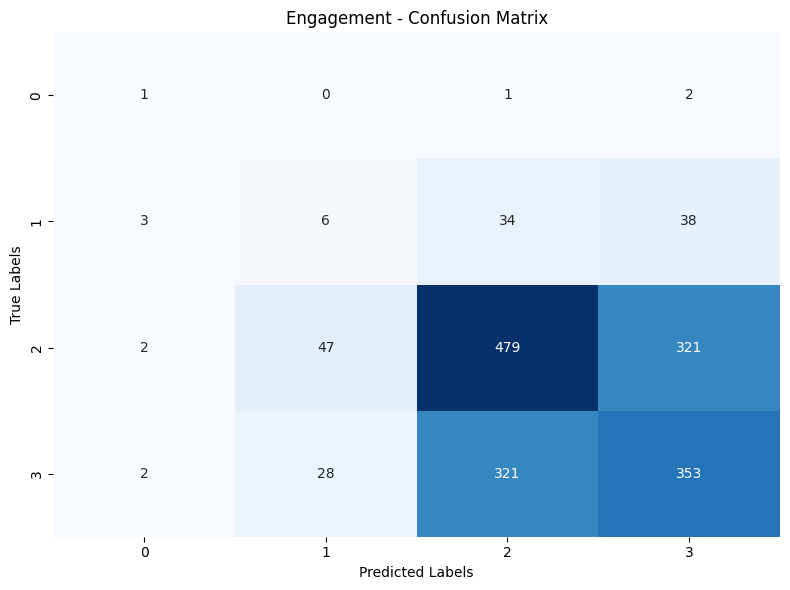

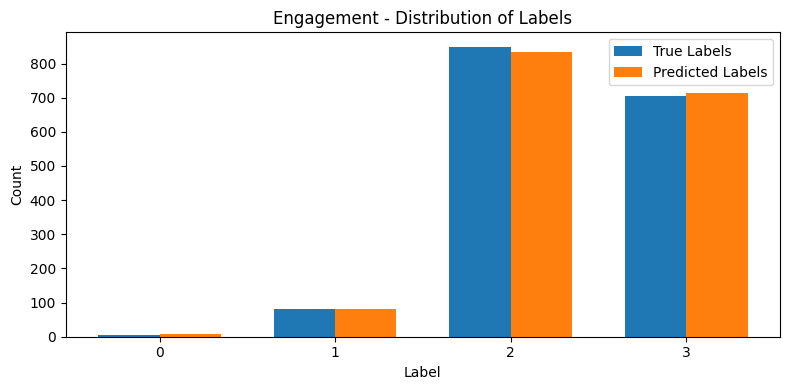

Classification report for Boredom:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       747
           1       0.38      0.38      0.38       519
           2       0.17      0.16      0.17       335
           3       0.06      0.05      0.06        37

    accuracy                           0.38      1638
   macro avg       0.28      0.28      0.28      1638
weighted avg       0.38      0.38      0.38      1638

Confusion Matrix:
[[376 179 181  11]
 [224 197  87  11]
 [146 126  55   8]
 [  9  22   4   2]]


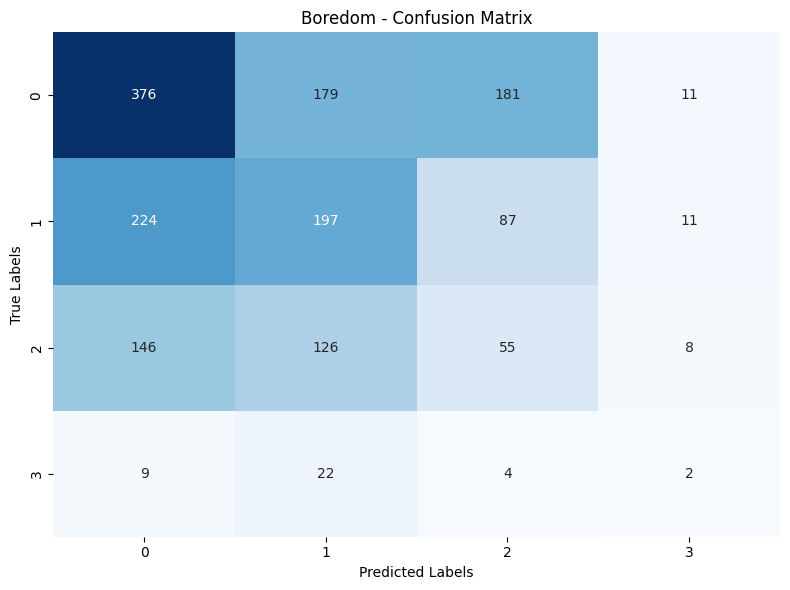

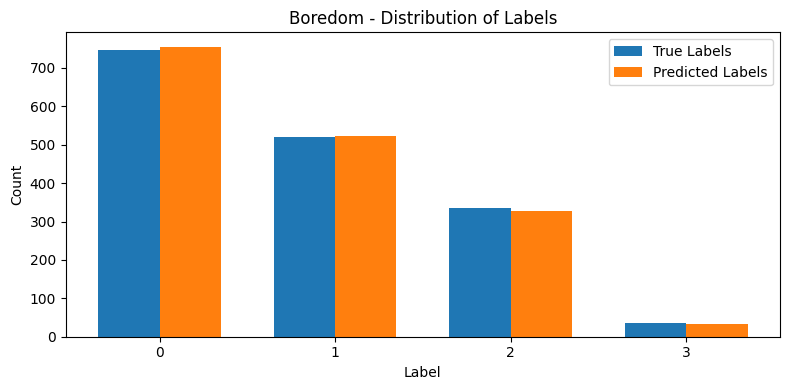

Classification report for Confusion:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      1135
           1       0.20      0.20      0.20       368
           2       0.01      0.01      0.01       116
           3       0.00      0.00      0.00        19

    accuracy                           0.50      1638
   macro avg       0.22      0.21      0.22      1638
weighted avg       0.50      0.50      0.50      1638

Confusion Matrix:
[[739 277 102  17]
 [272  73  19   4]
 [105  10   1   0]
 [ 19   0   0   0]]


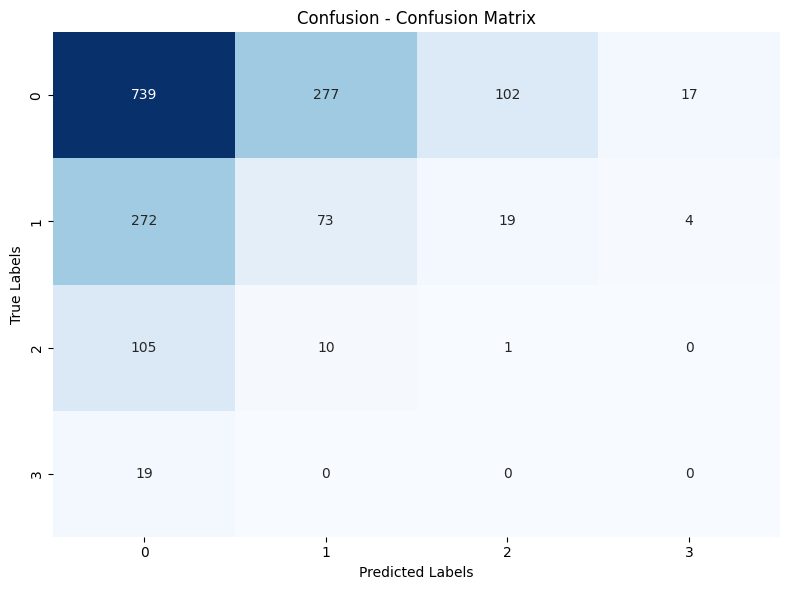

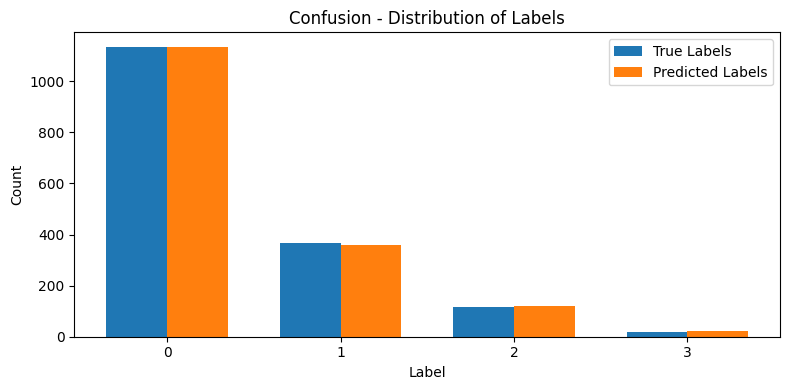

Classification report for Frustration:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1279
           1       0.11      0.11      0.11       280
           2       0.02      0.02      0.02        56
           3       0.00      0.00      0.00        23

    accuracy                           0.61      1638
   macro avg       0.22      0.22      0.22      1638
weighted avg       0.61      0.61      0.61      1638

Confusion Matrix:
[[960 241  52  26]
 [246  30   4   0]
 [ 49   6   1   0]
 [ 22   1   0   0]]


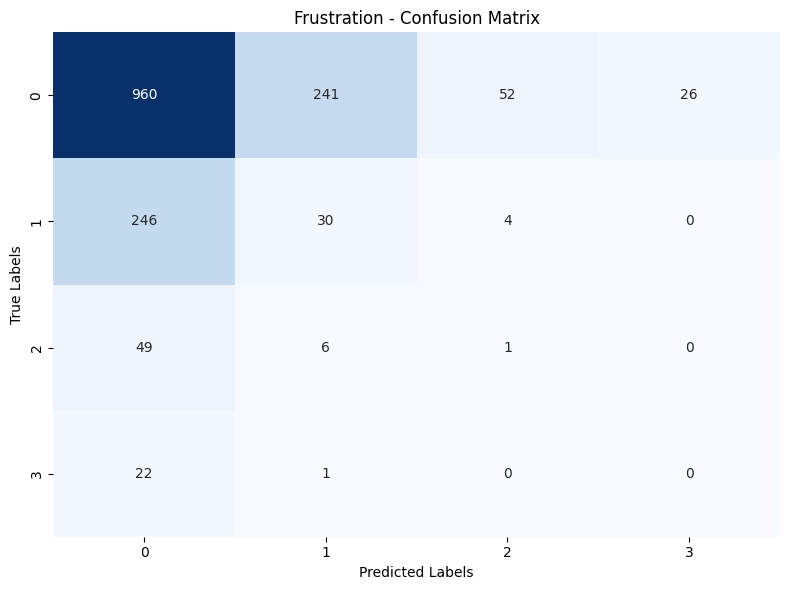

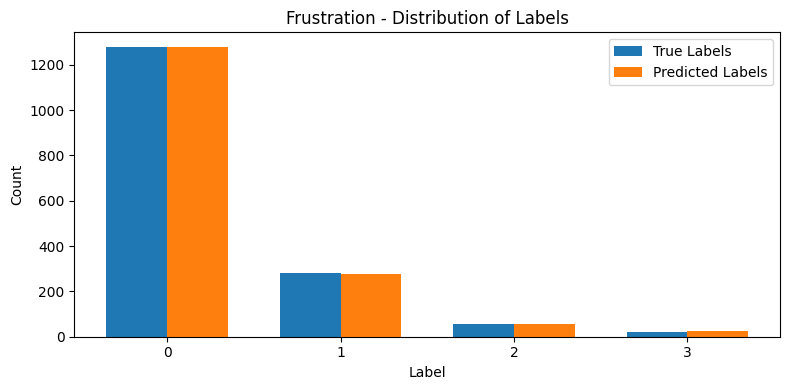


--- Evaluation Complete ---


In [5]:
# ------------------------------
# Main Execution
# ------------------------------
if __name__ == "__main__":
    # torch.multiprocessing.set_start_method('spawn')
    import io  # needed for LMDB conversion
    # CSV file paths
    train_csv = LABELS_DIR / "TrainLabels.csv"
    val_csv = LABELS_DIR / "ValidationLabels.csv"
    test_csv = LABELS_DIR / "TestLabels.csv"
    
    # Precompute frames and convert to LMDB for all splits (reusing your existing 224×224 files)
    for csv in [train_csv, val_csv, test_csv]:
        precompute_best_frames(csv, FRAMES_DIR, NUM_FRAMES)
        convert_pkl_to_lmdb(csv, NUM_FRAMES, transform=train_transform, lmdb_map_size=1 * 1024**3)
    
    # Hyperparameter Tuning with Optuna (LMDB dataset)
    db_path = BASE_DIR / "notebooks" / "tuning_eff_v2l.db"
    db_path.parent.mkdir(parents=True, exist_ok=True)
    try:
        conn = sqlite3.connect(db_path)
        print(f"Database created/connected successfully at: {db_path}")
        conn.close()
    except Exception as e:
        print(f"Error: {e}")
    study = optuna.create_study(
        direction="minimize",
        pruner=MedianPruner(n_startup_trials=2, n_warmup_steps=10),
        study_name="efficientnetv2l_tcn_cbam_study",
        storage=f"sqlite:///{db_path}",
        load_if_exists=True
    )
    n_trials_target = 20
    while True:
        successful_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and np.isfinite(t.value)]
        remaining = n_trials_target - len(successful_trials)
        if remaining <= 0:
            break
        print(f"Running {remaining} additional trial(s) to reach {n_trials_target} successful trials...")
        study.optimize(objective, n_trials=remaining, catch=(Exception,))
    print(f"Optuna tuning complete. Total successful trials: {len(successful_trials)}")
    best_trial = min(successful_trials, key=lambda t: t.value)
    print(f"Best trial parameters: {best_trial.params}")
    
    # Final Training with Best Hyperparameters (LMDB dataset)
    final_checkpoint = MODEL_DIR / "final_model_eff_v2l_checkpoint.pth"
    if not final_checkpoint.exists():
        print("\n--- Starting Final Training ---")
        params = best_trial.params
        num_frames = params.get("num_frames", NUM_FRAMES)
        # batch_size = 8  # Use a fixed batch size for final training
        batch_size = params.get("batch_size", 8)  # Uncomment if you want to use the best trial's batch size
        lr = params.get("lr", 1e-4)
        epochs = params.get("epochs", 5)
        hidden_size = params.get("hidden_size", 64)
        num_lstm_layers = params.get("num_lstm_layers", 1)
        
        train_set = VideoDatasetLMDB(train_csv, CACHE_DIR / f"lmdb_{train_csv.stem}_frame_{NUM_FRAMES}", num_frames=num_frames)
        val_set = VideoDatasetLMDB(val_csv, CACHE_DIR / f"lmdb_{val_csv.stem}_frame_{NUM_FRAMES}", num_frames=num_frames)
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
        
        final_model = EfficientNetV2L_TCN_CBAM(feature_dim=1536, hidden_size=hidden_size, num_layers=num_lstm_layers).to(device)
        final_checkpoint.parent.mkdir(parents=True, exist_ok=True)
        try:
            train_model(final_model, train_loader, val_loader, epochs, lr, final_checkpoint,
                        patience=5, gradient_accum_steps=GRADIENT_ACCUM_STEPS)
        except RuntimeError as e:
            print(f"Training failed: {e}")
            exit(1)
        if not final_checkpoint.exists():
            print("ERROR: Final checkpoint not created!")
            exit(1)
    else:
        print("\n--- Skipping Final Training (Checkpoint Exists) ---")
        print(f"Using existing model from: {final_checkpoint}")
    
    # Evaluation (LMDB dataset)
    test_set = VideoDatasetLMDB(test_csv, CACHE_DIR / f"lmdb_{test_csv.stem}_frame_{NUM_FRAMES}", num_frames=NUM_FRAMES)
    test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)
    eval_model = EfficientNetV2L_TCN_CBAM(feature_dim=1536, hidden_size=best_trial.params.get("hidden_size", 64),
                                           num_layers=best_trial.params.get("num_lstm_layers", 1)).to(device)
    state = torch.load(final_checkpoint, map_location=device)
    eval_model.load_state_dict(state["model_state_dict"])
    eval_model.to(device)
    evaluate_model(eval_model, test_loader)
    torch.cuda.empty_cache()
    gc.collect()
    print("\n--- Evaluation Complete ---")
